# Clustering audio à partir des fichiers chroma

On commence ici par étudier le datatset Cross-composer composé d'oeuvres de 11 compositeurs, l'objectif étant d'élargir avec le dataset Cross-era qui pourrait permettre de faire du clustering sur des périodes musicales.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

In [3]:
filename = "cross-composer\chroma-nnls_01_bach.csv"
li_notes = ['time','A','A#','B','C','C#','D','D#','E','F','F#','G','G#']

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\PCAJM\AppData\Local\Temp\ipykernel_11656\2910331894.py:1: SyntaxWarning: invalid escape sequence '\c'
  filename = "cross-composer\chroma-nnls_01_bach.csv"


## Récupération du fichier et conversion en format libre

In [4]:
def csv_to_windows(filename, window_size, hop_length):
    """
    Reads a CSV file and returns a list of windows.
    """
    li_notes = ['time','A','A#','B','C','C#','D','D#','E','F','F#','G','G#']
    df = pd.read_csv(filename)
    title = None
    dataf = []
    dataframes = {}
    for i, row in df.iterrows():
        if pd.notna(row[0]):
            if title is not None:
                dataframes[title] = pd.DataFrame(dataf, columns=li_notes)
                dataframes[title].set_index('time', inplace=True)
            title = row[0]
            dataf = []
        else:
            dataf.append(row[1:].tolist())
    
    if title is not None:
        dataframes[title] = pd.DataFrame(dataf, columns=li_notes)
        dataframes[title].set_index('time', inplace=True)
    
    windows = []
    for title, df in dataframes.items():
        num_windows = (len(df) - window_size) // hop_length + 1

        for i in range(num_windows):
            start = i * hop_length
            end = start + window_size
            if end < len(df):
                windows.append((title,start,df.iloc[start:end].values))
    
    return windows 

In [5]:
def chromagram(data):
    li_notes = ['A','A#','B','C','C#','D','D#','E','F','F#','G','G#']
    plt.figure(figsize=(10, 4))
    plt.imshow(data.T, aspect='auto', origin='lower', cmap='coolwarm')
    plt.colorbar(label='Energy')
    plt.title('Chromagram')
    plt.xlabel('Time (Frames)')
    plt.ylabel('Chroma Features')
    #plt.xticks(ticks=np.arange(0, 100, 10), labels=np.arange(0, 100, 10))  # Ajustez les ticks si nécessaire
    plt.yticks(ticks=np.arange(12), labels=li_notes)  # Noms des chroma
    plt.tight_layout()
    plt.show()

In [6]:
windows = csv_to_windows(filename, 50, 10)
with open ('windows_bach.pkl', 'wb') as f:
    pickle.dump(windows, f)

C:\Users\PCAJM\AppData\Local\Temp\ipykernel_11656\2440232101.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.notna(row[0]):
C:\Users\PCAJM\AppData\Local\Temp\ipykernel_11656\2440232101.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  title = row[0]


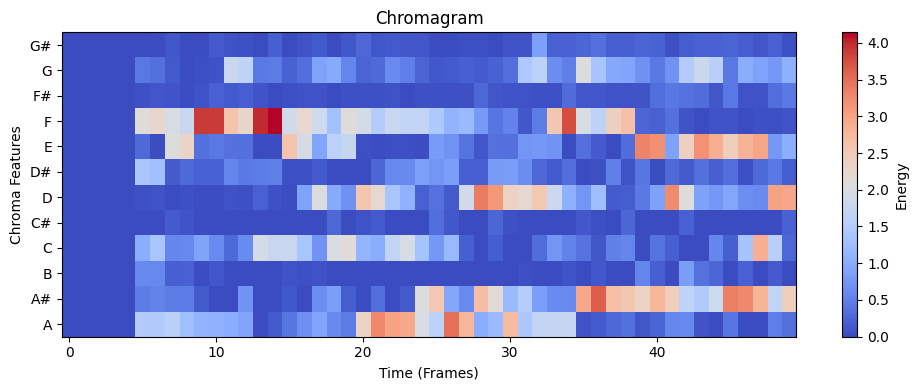

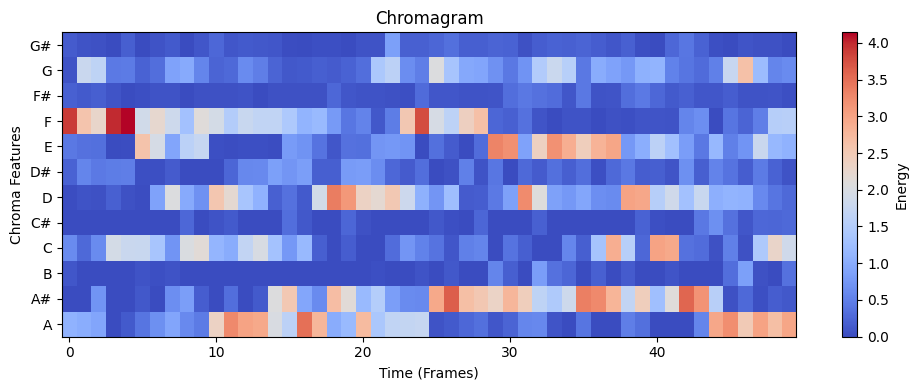

In [7]:
for i in range(2):
    chromagram(windows[i][2])

## Pre-processing des données

In [8]:
data = pickle.load(open('windows_bach.pkl', 'rb'))

In [9]:
np.array([data[i][2].flatten() for i in range(len(data))])[0]

array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       1.48103e+00, 4.71290e-01, 6.07978e-01, 1.00695e+00, 1.65767e-03,
       5.11324e-02, 1.37932e+00, 2.86185e-01, 2.11538e+00, 4.979

In [15]:
def k_means_clustering(data, n_clusters=10):
    """
    Applies KMeans clustering to the data.
    """
    data_flattened = np.array([data[i][2].flatten() for i in range(len(data))])
    identifiers = np.array([(data[i][0],data[i][1]) for i in range(len(data))])
    kmeans = KMeans(n_clusters = n_clusters, random_state=42)
    clusters = kmeans.fit_predict(data_flattened)
    results = np.column_stack((identifiers, clusters))
    return data_flattened,results, kmeans.cluster_centers_

In [16]:
data_flattened,res, centroids = k_means_clustering(data, n_clusters=10)

In [12]:
res[:,2]

array(['2', '0', '0', ..., '7', '7', '7'], dtype='<U110')

In [13]:
def affichage(data_flattened, resultats):
    pca = PCA(n_components=2)
    data_reduced = pca.fit_transform(data_flattened)
    df = pd.DataFrame(data_reduced, columns=['PC1', 'PC2'])
    df['Cluster'] = resultats[:,2]
    df['Title'] = resultats[:,0]
    df['Start'] = resultats[:,1]
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster', palette='viridis', s=10, alpha=0.7)

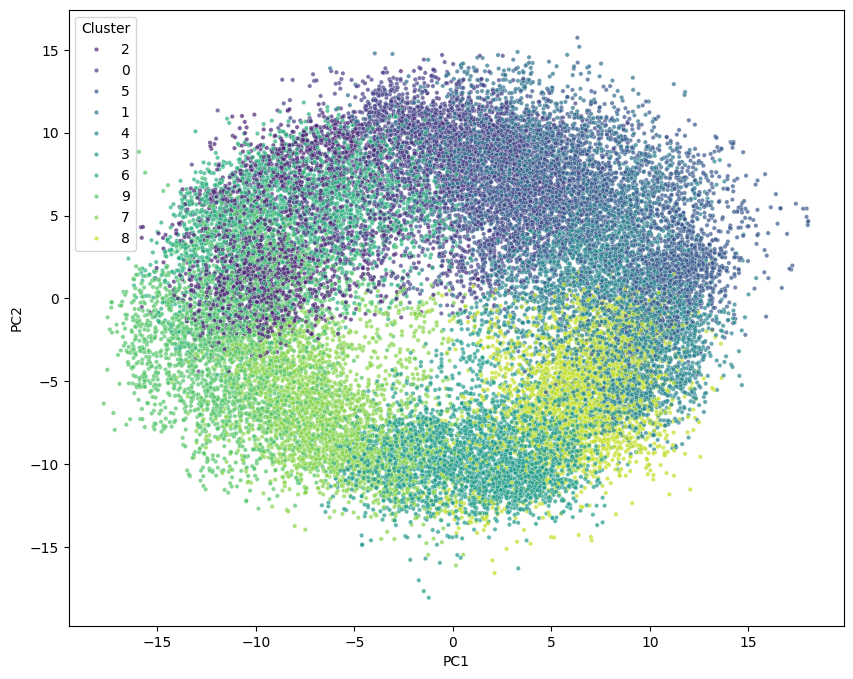

In [14]:
affichage(data_flattened,res)

In [25]:
def affichage_centroides(data_flattened, resultats, centroids):
    pca = PCA(n_components=2)
    data_reduced = pca.fit_transform(data_flattened)
    df = pd.DataFrame(data_reduced, columns=['PC1', 'PC2'])
    df['Cluster'] = resultats[:,2]
    df['Title'] = resultats[:,0]
    df['Start'] = resultats[:,1]
    plt.figure(figsize=(10, 8))
    centroids = pca.transform(centroids)
    sns.scatterplot(data=df, x='PC1', y='PC2', hue='Title', palette='viridis', s=10, alpha=0.5, legend = False)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

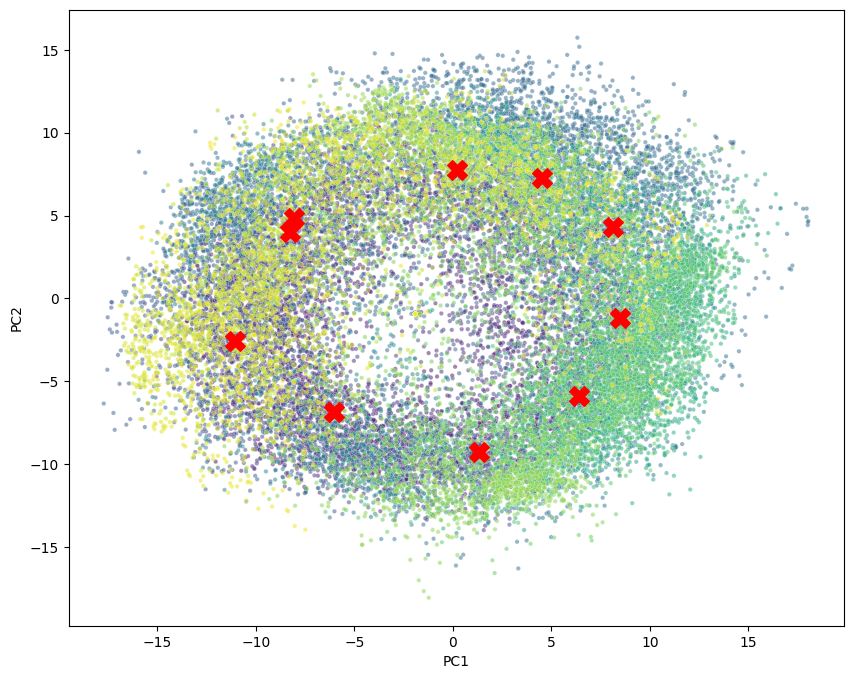

In [26]:
affichage_centroides(data_flattened,res, centroids)